#Kamal's Code:


In [0]:
from random import randint, choice
from pprint import pprint
from itertools import permutations
from math import inf as oo # Infinity (∞) is larger than any number
from math import sqrt
from time      import time
import matplotlib.pyplot as plt
import copy

In [0]:
MAX_DISTANCE = 100

def random_symmetric_graph(n):
    ''' Symmetric adjacency matrix of size nxn '''
    dist_matrix = [[oo for _ in range(n)] for _ in range(n)]
    for i in range(n):
        for j in range(i+1,n):
            v = randint(1,MAX_DISTANCE)
            dist_matrix[i][j] = v
            dist_matrix[j][i] = v
    return dist_matrix

def random_euclidean_graph(n):
    ''' Symmetric adjacency matrix of a Euclidean graph of size nxn '''
    dist_matrix = [[oo for _ in range(n)] for _ in range(n)]
    points = []
    for p in range(n):
        x,y = randint(0,MAX_DISTANCE), randint(0,MAX_DISTANCE)
        points.append((x,y))
    for i in range(n):
        p1 = points[i]
        for j in range(i+1,n):
            p2 = points[j]
            distance = sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)
            dist_matrix[i][j] = distance
            dist_matrix[j][i] = distance
    return dist_matrix

def show(G):
    ''' Show adjacency matrix. Useful for debugging. '''
    n = len(G)
    r = "     "
    for i in range(n):
        r += f'{i:4}'
    r += '\n    -'+'-'*(4*n)+'\n'
    for i in range(n):
        r += f'{i:2} | '
        for j in range(n):
            r += f'{G[i][j]:4}'
        r += '\n'
    r = r.replace('inf', '  ∞')
    print(r)

def cost(G, cycle):
    ''' Calculate the cost of the given cycle '''
    c = 0
    n = len(G)
    for i in range(n):
        a = cycle[i]
        b = cycle[(i+1)%n]
        c += G[a][b]
    return c
    
def greedy_nearest_neighbours(G):
    H = copy.deepcopy(G) # We need the original G. We work on/modify H
    n = len(H)
    cities = list(range(n))
    cycle = [] # solution to be built
    city = 0 # Start city
    while len(cities)>0:
        # Find nearest neighbour
        city_neighbours = H[city]
        smallest_distance = min(city_neighbours)
        nearest_city = city_neighbours.index(smallest_distance)
        # Update 'cycle' and 'cities' and H then 'city'
        cycle.append(city)
        cities.remove(city)
        for i in range(n): # 'city' is not to be used again!
            H[city][i] = oo
            H[i][city] = oo
        city = nearest_city
    return (cycle, cost(G, cycle))

def exhaustive_search(G):
    n = len(G)    
    best_cost = oo # infinity
    best_cycle = []
    for cycle in permutations(range(1,n)): # permutations of [1,2,...,n-1]
        cycle=[0]+list(cycle)              # add the starting city: 0
        c = cost(G, cycle)
        if c < best_cost:
            best_cost = c
            best_cycle = cycle
    return (best_cycle, best_cost)

# Best Algorithm TSP, ref: https://github.com/dmishin/tsp-solver

In [0]:
from tsp_solver.greedy import solve_tsp
import tsp_solver

# Benchmarking (Serge)

In [0]:
def benchmark_solver(suboptimal_algorithm, dataset, times=1):
    """
    params: 
    suboptimal_algorithm  --> Pointer to algorithm you want to benchmark
    times                 --> Amount of times algorithm should run
    dataset               --> List of graphs you want benchmarked """

    allPaths = []
    for i in range(times):
        for graph in dataset: #looping over graphs
            start = time()
            pathAlgorithm = suboptimal_algorithm(graph)
            suboptimalTime = time() - start

            start = time()
            bestPath = solve_tsp(graph, endpoints=(0, pathAlgorithm[0][-1]))
            correctTime = time() - start
                                #so it starts and begins at the same point
            allPaths.append((bestPath, pathAlgorithm[0], correctTime, suboptimalTime))

    return allPaths


# Canvassing 


In [0]:
graphList = []
for i in range(2, 201): # Create 100 graphs of sizes [2,101]
    for j in range(25): # do it 25 times each
        graphList.append(random_symmetric_graph(i))

# Exhaustive Processing

In [0]:
exhaustiveSolutions = []
t0 = t1 = 0

for graph in graphList:
    t0 = time()
    solution = exhaustive_search(graph)
    t1 = time()
    exhaustiveSolutions.append((solution[0], t1-t0))
    if t1-t0 > 3:
        break

In [0]:
def get_separate_exhaustive(graphList, exhaustiveSolutions):

    allCosts = []
    allTimes = []
    averageCounter = 0
    totalCosts = 0
    totalTimes = 0 
    currentSize = 2

    for solution, graph in zip(exhaustiveSolutions, graphList):
        if len(solution[0]) == currentSize: #so we average the same size graphs
            totalCosts += cost(graph, solution[0])
            totalTimes += solution[1]
            averageCounter += 1
        else:
            allCosts.append(round(totalCosts / averageCounter))
            allTimes.append(round(totalTimes / averageCounter, 3))
            totalCosts = 0
            totalTimes = 0 
            averageCounter = 0
            currentSize = len(solution[0]) #advance onto the next size

    return allCosts, allTimes

In [0]:
exhaustiveCosts, exhaustiveTimes = get_separate_exhaustive(graphList, exhaustiveSolutions)


# TSP Solver and GreedyNN

In [0]:
allSolutions = benchmark_solver(greedy_nearest_neighbours, graphList)

In [0]:
def get_percentage_delta(graphList, allSolutions):
    """ allSolutions = [(solution0, solution1), ...]
        solution0 being always the correct one"""

    correctCostTotal = 0
    suboptimalCostTotal = 0 
    percentageDelta = []
    currentSize = 2 #always start at length 2

    for solution, graph in zip(allSolutions, graphList):
        if len(solution[0]) == currentSize: #so we average the same size graphs
            correctCostTotal += cost(graph, solution[0])
            suboptimalCostTotal += cost(graph, solution[1])
        else:
            percentageDelta.append(correctCostTotal / suboptimalCostTotal * 100)
            correctCostTotal = 0
            suboptimalCostTotal = 0 
            currentSize = len(solution[0]) #advance onto the next size

    return percentageDelta

percentageDelta = get_percentage_delta(graphList, allSolutions)

In [0]:
def get_separate_costs(graphList, allSolutions):
    """ allSolutions = [(solution0, solution1), ...]
        solution0 being always the correct one"""

    suboptimalCosts = []
    correctCosts = []

    correctCostTotal = 0
    suboptimalCostTotal = 0 
    averageCounter = 0
    currentSize = 2 #always start at length 2
    for solution, graph in zip(allSolutions, graphList):
        if len(solution[0]) == currentSize: #so we average the same size graphs
            correctCostTotal += cost(graph, solution[0])
            suboptimalCostTotal += cost(graph, solution[1])
            averageCounter += 1
        else:
            suboptimalCosts.append(suboptimalCostTotal / averageCounter)
            correctCosts.append(correctCostTotal / averageCounter)
            suboptimalCostTotal = 0 
            correctCostTotal = 0
            averageCounter = 0
            currentSize = len(solution[0]) #advance onto the next size

    return (suboptimalCosts, correctCosts)

In [0]:
def get_separate_times(graphList, allSolutions):
    """ allSolutions = [(solution0, solution1), ...]
        solution0 being always the correct one"""

    suboptimalTime = []
    correctTime = []

    correctTimeTotal = 0
    suboptimalTimeTotal = 0 
    averageCounter = 0
    currentSize = 2 #always start at length 2
    for solution, graph in zip(allSolutions, graphList):
        if len(solution[0]) == currentSize: #so we average the same size graphs
            correctTimeTotal += solution[2]
            suboptimalTimeTotal += solution[3]
            averageCounter += 1
        else:
            suboptimalTime.append(suboptimalTimeTotal / averageCounter)
            correctTime.append(correctTimeTotal / averageCounter)
            suboptimalTimeTotal = 0 
            correctTimeTotal = 0
            averageCounter = 0
            currentSize = len(solution[0]) #advance onto the next size

    return (suboptimalTime, correctTime)


## Percentage Drop-Off GreedyNN vs TSP-Solver


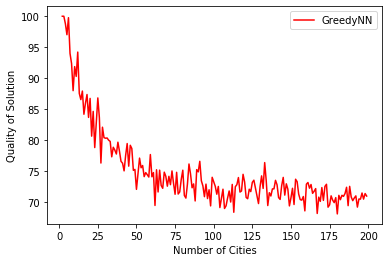

In [138]:
plt.plot(range(2, 200) , percentageDelta, 'r', label="GreedyNN")
plt.xlabel("Number of Cities")
plt.ylabel("Quality of Solution")
plt.legend()
plt.show()

## Averaged Costs Of All Approaches

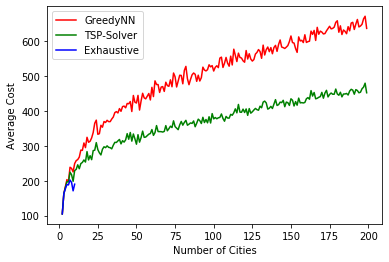

In [174]:
suboptimalCosts, correctCosts = get_separate_costs(graphList, allSolutions)

plt.plot(range(2, 200) , suboptimalCosts, 'r', label="GreedyNN")
plt.plot(range(2, 200) , correctCosts, 'g', label="TSP-Solver")
plt.plot(range(2, 11) , exhaustiveCosts, 'b', label="Exhaustive")
plt.xlabel("Number of Cities")
plt.ylabel("Average Cost")
plt.legend()
plt.show()

## Time: GreedyNN vs Exhaustive

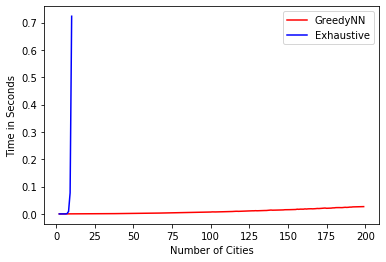

In [176]:
suboptimalTimes, correctTimes = get_separate_times(graphList, allSolutions)

plt.plot(range(2, 200) , suboptimalTimes, 'r', label="GreedyNN")
plt.plot(range(2, 11) , exhaustiveTimes, 'b', label="Exhaustive")
plt.xlabel("Number of Cities")
plt.ylabel("Time in Seconds")
plt.legend()
plt.show()

## Time: GreedyNN vs TSP-Solver

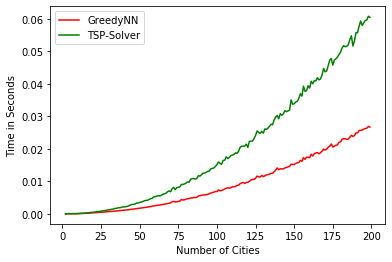

In [168]:
plt.plot(range(2, 200) , suboptimalTimes, 'r', label="GreedyNN")
plt.plot(range(2, 200) , correctTimes, 'g', label="TSP-Solver")
plt.xlabel("Number of Cities")
plt.ylabel("Time in Seconds")
plt.legend()
plt.show()